In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import contractions
import sys
import os
os.path.abspath(os.curdir)
os.chdir("..")
ML_FOLDER_PATH = os.path.abspath(os.curdir)
sys.path.append(ML_FOLDER_PATH)
import src.helpers as hlp

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
VECT_DIM = 200

In [3]:
embeddings = torchtext.vocab.GloVe(name="twitter.27B", dim=VECT_DIM, max_vectors=1000000)

### Data processing

In [4]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

In [5]:
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_punct(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.add_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_white_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.to_lower(x))
df['tweet'] = df['tweet'].apply(lambda x: contractions.fix(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_single_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.lemmatize(x))

### Vectorization

In [6]:
def vectorize(tweets):
    vectorized_tweets_np = np.ones((len(tweets),VECT_DIM+1))
    not_in_embed = 0
    nb_words = 0
    for i, tweet in enumerate(tqdm(tweets)):
        tweet_len = len(tweet.split(' '))
        tweet_embedding=np.zeros((tweet_len,VECT_DIM))
        for j, word in enumerate(tweet.split(' ')):
            nb_words += 1
            tweet_embedding[j] = embeddings[word]
            if torch.equal(embeddings[word],torch.zeros(VECT_DIM)):
                not_in_embed+=1
        vectorized_tweets_np[i, 1:] = tweet_embedding.sum(0)
    print(not_in_embed/nb_words)
    return vectorized_tweets_np

In [7]:
X = vectorize(df.tweet)
y = df['label'].values

100%|██████████| 196970/196970 [00:33<00:00, 5832.21it/s]

0.027150685500539676


In [8]:
X.shape

(196970, 201)

### Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

### Bernouilli Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

BernoulliNB()

In [11]:
y_pred3 = BNB.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66      9951
           1       0.66      0.69      0.68      9746

    accuracy                           0.67     19697
   macro avg       0.67      0.67      0.67     19697
weighted avg       0.67      0.67      0.67     19697



### Neuronal Network

In [12]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [13]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [14]:
y_test = np.where(y_test == -1, 0, y_test)
y_train = np.where(y_train == -1, 0, y_train)

In [15]:
train_data = TrainDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_data = TrainDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [16]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [18]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [19]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [20]:
model = nn.Sequential(nn.Linear(VECT_DIM+1, 200),
                        nn.Sigmoid(),
                        nn.Dropout(p=0.5),
                        nn.Linear(200, 50),
                        nn.Sigmoid(),
                        nn.Dropout(p=0.5),
                        nn.Linear(50, 2),
                        nn.Softmax(1))

Epoch : 1



100%|██████████| 2770/2770 [00:09<00:00, 282.25it/s]


Train Error: 
 Accuracy: 76.0%, Avg loss: 0.537510 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.519260 

Epoch : 2



100%|██████████| 2770/2770 [00:09<00:00, 305.51it/s]


Train Error: 
 Accuracy: 78.3%, Avg loss: 0.516888 

Test Error: 
 Accuracy: 78.4%, Avg loss: 0.515337 

Epoch : 3



100%|██████████| 2770/2770 [00:08<00:00, 326.11it/s]


Train Error: 
 Accuracy: 78.9%, Avg loss: 0.511457 

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.511113 

Epoch : 4



100%|██████████| 2770/2770 [00:09<00:00, 302.83it/s]


Train Error: 
 Accuracy: 79.3%, Avg loss: 0.507737 

Test Error: 
 Accuracy: 79.1%, Avg loss: 0.508991 

Epoch : 5



100%|██████████| 2770/2770 [00:08<00:00, 339.35it/s]


Train Error: 
 Accuracy: 79.5%, Avg loss: 0.505131 

Test Error: 
 Accuracy: 79.2%, Avg loss: 0.508562 

Epoch : 6



100%|██████████| 2770/2770 [00:08<00:00, 337.43it/s]


Train Error: 
 Accuracy: 79.8%, Avg loss: 0.503201 

Test Error: 
 Accuracy: 79.2%, Avg loss: 0.507602 

Epoch : 7



100%|██████████| 2770/2770 [00:09<00:00, 297.91it/s]


Train Error: 
 Accuracy: 80.2%, Avg loss: 0.500485 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.506498 

Epoch : 8



100%|██████████| 2770/2770 [00:09<00:00, 294.96it/s]


Train Error: 
 Accuracy: 80.4%, Avg loss: 0.498817 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.506902 

Epoch : 9



100%|██████████| 2770/2770 [00:10<00:00, 260.04it/s]


Train Error: 
 Accuracy: 80.5%, Avg loss: 0.497691 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.504724 

Epoch : 10



100%|██████████| 2770/2770 [00:09<00:00, 282.98it/s]


Train Error: 
 Accuracy: 80.6%, Avg loss: 0.495813 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.505494 

Epoch : 11



100%|██████████| 2770/2770 [00:09<00:00, 283.94it/s]


Train Error: 
 Accuracy: 80.8%, Avg loss: 0.494946 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504196 

Epoch : 12



100%|██████████| 2770/2770 [00:10<00:00, 252.55it/s]


Train Error: 
 Accuracy: 80.9%, Avg loss: 0.493568 

Test Error: 
 Accuracy: 79.4%, Avg loss: 0.505468 

Epoch : 13



100%|██████████| 2770/2770 [00:08<00:00, 327.68it/s]


Train Error: 
 Accuracy: 81.1%, Avg loss: 0.492756 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.505529 

Epoch : 14



100%|██████████| 2770/2770 [00:20<00:00, 135.57it/s]


Train Error: 
 Accuracy: 81.2%, Avg loss: 0.491611 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.502825 

Epoch : 15



100%|██████████| 2770/2770 [00:11<00:00, 243.53it/s]


Train Error: 
 Accuracy: 81.3%, Avg loss: 0.490305 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504638 

Epoch : 16



100%|██████████| 2770/2770 [00:11<00:00, 236.75it/s]


Train Error: 
 Accuracy: 81.4%, Avg loss: 0.489472 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503359 

Epoch : 17



100%|██████████| 2770/2770 [00:10<00:00, 258.95it/s]


Train Error: 
 Accuracy: 81.4%, Avg loss: 0.489040 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504795 

Epoch : 18



100%|██████████| 2770/2770 [00:10<00:00, 259.51it/s]


Train Error: 
 Accuracy: 81.6%, Avg loss: 0.488084 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503908 

Epoch : 19



100%|██████████| 2770/2770 [00:13<00:00, 205.18it/s]


Train Error: 
 Accuracy: 81.6%, Avg loss: 0.487314 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.501760 

Epoch : 20



100%|██████████| 2770/2770 [00:13<00:00, 212.83it/s]


Train Error: 
 Accuracy: 81.8%, Avg loss: 0.486294 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503879 

Epoch : 21



100%|██████████| 2770/2770 [00:10<00:00, 261.06it/s]


Train Error: 
 Accuracy: 81.9%, Avg loss: 0.485353 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504083 

Epoch : 22



100%|██████████| 2770/2770 [00:10<00:00, 253.03it/s]


Train Error: 
 Accuracy: 81.8%, Avg loss: 0.485596 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.503717 

Epoch : 23



100%|██████████| 2770/2770 [00:10<00:00, 260.98it/s]


Train Error: 
 Accuracy: 82.0%, Avg loss: 0.484368 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.502912 

Epoch : 24



100%|██████████| 2770/2770 [00:10<00:00, 270.82it/s]


Train Error: 
 Accuracy: 82.1%, Avg loss: 0.483813 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503372 

Epoch : 25



100%|██████████| 2770/2770 [00:10<00:00, 261.24it/s]


Train Error: 
 Accuracy: 82.1%, Avg loss: 0.483086 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503390 

Epoch : 26



100%|██████████| 2770/2770 [00:10<00:00, 273.53it/s]


Train Error: 
 Accuracy: 82.1%, Avg loss: 0.482922 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504109 

Epoch : 27



100%|██████████| 2770/2770 [00:11<00:00, 231.06it/s]


Train Error: 
 Accuracy: 82.3%, Avg loss: 0.481742 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.505025 

Epoch : 28



100%|██████████| 2770/2770 [00:12<00:00, 226.91it/s]


Train Error: 
 Accuracy: 82.4%, Avg loss: 0.480909 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504093 

Epoch : 29



100%|██████████| 2770/2770 [00:11<00:00, 240.13it/s]


Train Error: 
 Accuracy: 82.5%, Avg loss: 0.480608 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503360 

Epoch : 30



100%|██████████| 2770/2770 [00:12<00:00, 224.77it/s]


Train Error: 
 Accuracy: 82.5%, Avg loss: 0.480314 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504755 

Epoch : 31



100%|██████████| 2770/2770 [00:12<00:00, 229.78it/s]


Train Error: 
 Accuracy: 82.5%, Avg loss: 0.480154 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504240 

Epoch : 32



100%|██████████| 2770/2770 [00:10<00:00, 255.49it/s]


Train Error: 
 Accuracy: 82.6%, Avg loss: 0.479198 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.501575 

Epoch : 33



100%|██████████| 2770/2770 [00:09<00:00, 285.84it/s]


Train Error: 
 Accuracy: 82.7%, Avg loss: 0.478874 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.503111 

Epoch : 34



100%|██████████| 2770/2770 [00:09<00:00, 290.30it/s]


Train Error: 
 Accuracy: 82.6%, Avg loss: 0.478391 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.502855 

Epoch : 35



100%|██████████| 2770/2770 [00:11<00:00, 250.47it/s]


Train Error: 
 Accuracy: 82.7%, Avg loss: 0.477979 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.502351 

Epoch : 36



100%|██████████| 2770/2770 [00:12<00:00, 227.84it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.476838 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503375 

Epoch : 37



100%|██████████| 2770/2770 [00:15<00:00, 177.83it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.477186 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.505067 

Epoch : 38



100%|██████████| 2770/2770 [00:12<00:00, 228.34it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.476045 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503298 

Epoch : 39



100%|██████████| 2770/2770 [00:12<00:00, 215.71it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.476956 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.501829 

Epoch : 40



100%|██████████| 2770/2770 [00:13<00:00, 208.68it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.475977 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504611 

Epoch : 41



100%|██████████| 2770/2770 [00:12<00:00, 218.46it/s]


Train Error: 
 Accuracy: 83.0%, Avg loss: 0.475329 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503046 

Epoch : 42



100%|██████████| 2770/2770 [00:13<00:00, 203.38it/s]


Train Error: 
 Accuracy: 83.0%, Avg loss: 0.475285 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503952 

Epoch : 43



100%|██████████| 2770/2770 [00:12<00:00, 215.41it/s]


Train Error: 
 Accuracy: 83.2%, Avg loss: 0.474553 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503586 

Epoch : 44



100%|██████████| 2770/2770 [00:17<00:00, 154.89it/s]


Train Error: 
 Accuracy: 83.1%, Avg loss: 0.475028 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.504788 

Epoch : 45



100%|██████████| 2770/2770 [00:14<00:00, 192.12it/s]


Train Error: 
 Accuracy: 83.1%, Avg loss: 0.474262 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.504074 

Epoch : 46



100%|██████████| 2770/2770 [00:12<00:00, 225.65it/s]


Train Error: 
 Accuracy: 83.3%, Avg loss: 0.473042 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503316 

Epoch : 47



100%|██████████| 2770/2770 [00:13<00:00, 204.62it/s]


Train Error: 
 Accuracy: 83.2%, Avg loss: 0.473613 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504357 

Epoch : 48



100%|██████████| 2770/2770 [00:14<00:00, 195.78it/s]


Train Error: 
 Accuracy: 83.3%, Avg loss: 0.473198 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504124 

Epoch : 49



100%|██████████| 2770/2770 [00:13<00:00, 212.06it/s]


Train Error: 
 Accuracy: 83.3%, Avg loss: 0.473100 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504394 

Epoch : 50



100%|██████████| 2770/2770 [00:11<00:00, 238.44it/s]


Train Error: 
 Accuracy: 83.4%, Avg loss: 0.472284 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.501981 

Epoch : 51



100%|██████████| 2770/2770 [00:13<00:00, 204.92it/s]


Train Error: 
 Accuracy: 83.3%, Avg loss: 0.472752 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.505658 

Epoch : 52



100%|██████████| 2770/2770 [00:11<00:00, 237.12it/s]


Train Error: 
 Accuracy: 83.4%, Avg loss: 0.472309 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.503046 

Epoch : 53



100%|██████████| 2770/2770 [00:12<00:00, 226.81it/s]


Train Error: 
 Accuracy: 83.4%, Avg loss: 0.472194 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.502900 

Epoch : 54



100%|██████████| 2770/2770 [00:13<00:00, 209.90it/s]


Train Error: 
 Accuracy: 83.5%, Avg loss: 0.471317 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503289 

Epoch : 55



100%|██████████| 2770/2770 [00:12<00:00, 230.83it/s]


Train Error: 
 Accuracy: 83.5%, Avg loss: 0.471260 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.503821 

Epoch : 56



100%|██████████| 2770/2770 [00:13<00:00, 201.32it/s]


Train Error: 
 Accuracy: 83.6%, Avg loss: 0.470581 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.502875 

Epoch : 57



100%|██████████| 2770/2770 [00:13<00:00, 205.82it/s]


Train Error: 
 Accuracy: 83.6%, Avg loss: 0.471145 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503105 

Epoch : 58



100%|██████████| 2770/2770 [00:13<00:00, 211.93it/s]


Train Error: 
 Accuracy: 83.7%, Avg loss: 0.469954 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504128 

Epoch : 59



100%|██████████| 2770/2770 [00:12<00:00, 218.92it/s]


Train Error: 
 Accuracy: 83.6%, Avg loss: 0.470602 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.504151 

Epoch : 60



100%|██████████| 2770/2770 [00:12<00:00, 221.95it/s]


Train Error: 
 Accuracy: 83.6%, Avg loss: 0.470407 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503233 

Epoch : 61



100%|██████████| 2770/2770 [00:13<00:00, 204.90it/s]


Train Error: 
 Accuracy: 83.6%, Avg loss: 0.470208 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504344 

Epoch : 62



100%|██████████| 2770/2770 [00:11<00:00, 241.87it/s]


Train Error: 
 Accuracy: 83.7%, Avg loss: 0.469366 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.505488 

Epoch : 63



100%|██████████| 2770/2770 [00:11<00:00, 240.66it/s]


Train Error: 
 Accuracy: 83.7%, Avg loss: 0.469623 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503795 

Epoch : 64



100%|██████████| 2770/2770 [00:12<00:00, 230.18it/s]


Train Error: 
 Accuracy: 83.7%, Avg loss: 0.469496 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503853 

Epoch : 65



100%|██████████| 2770/2770 [00:11<00:00, 245.91it/s]


Train Error: 
 Accuracy: 83.7%, Avg loss: 0.469123 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503699 

Epoch : 66



100%|██████████| 2770/2770 [00:13<00:00, 200.40it/s]


Train Error: 
 Accuracy: 83.8%, Avg loss: 0.468847 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503176 

Epoch : 67



100%|██████████| 2770/2770 [00:14<00:00, 191.55it/s]


Train Error: 
 Accuracy: 83.8%, Avg loss: 0.468640 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.504570 

Epoch : 68



100%|██████████| 2770/2770 [00:11<00:00, 247.41it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.467639 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.507155 

Epoch : 69



100%|██████████| 2770/2770 [00:11<00:00, 248.69it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.467740 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503537 

Epoch : 70



100%|██████████| 2770/2770 [00:11<00:00, 235.21it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.467911 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503570 

Epoch : 71



100%|██████████| 2770/2770 [00:11<00:00, 240.62it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.467385 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.503745 

Epoch : 72



100%|██████████| 2770/2770 [00:15<00:00, 178.44it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.466770 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506076 

Epoch : 73



100%|██████████| 2770/2770 [00:12<00:00, 216.27it/s]


Train Error: 
 Accuracy: 84.0%, Avg loss: 0.467073 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.504795 

Epoch : 74



100%|██████████| 2770/2770 [00:12<00:00, 224.56it/s]


Train Error: 
 Accuracy: 84.0%, Avg loss: 0.466975 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.505126 

Epoch : 75



100%|██████████| 2770/2770 [00:11<00:00, 233.27it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.467497 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.505697 

Epoch : 76



100%|██████████| 2770/2770 [00:12<00:00, 224.81it/s]


Train Error: 
 Accuracy: 84.1%, Avg loss: 0.465882 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.504895 

Epoch : 77



100%|██████████| 2770/2770 [00:12<00:00, 226.28it/s]


Train Error: 
 Accuracy: 84.0%, Avg loss: 0.466507 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506296 

Epoch : 78



100%|██████████| 2770/2770 [00:12<00:00, 220.57it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.465820 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.505247 

Epoch : 79



100%|██████████| 2770/2770 [00:13<00:00, 198.27it/s]


Train Error: 
 Accuracy: 84.1%, Avg loss: 0.466012 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.505878 

Epoch : 80



100%|██████████| 2770/2770 [00:11<00:00, 243.26it/s]


Train Error: 
 Accuracy: 84.1%, Avg loss: 0.466323 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506769 

Epoch : 81



100%|██████████| 2770/2770 [00:13<00:00, 200.83it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.465532 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.504431 

Epoch : 82



100%|██████████| 2770/2770 [00:13<00:00, 210.05it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.465024 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.503903 

Epoch : 83



100%|██████████| 2770/2770 [00:13<00:00, 209.14it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.465287 

Test Error: 
 Accuracy: 79.4%, Avg loss: 0.507054 

Epoch : 84



100%|██████████| 2770/2770 [00:11<00:00, 233.87it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.464932 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506030 

Epoch : 85



100%|██████████| 2770/2770 [00:11<00:00, 241.28it/s]


Train Error: 
 Accuracy: 84.3%, Avg loss: 0.464818 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506905 

Epoch : 86



100%|██████████| 2770/2770 [00:11<00:00, 238.65it/s]


Train Error: 
 Accuracy: 84.3%, Avg loss: 0.464535 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.506798 

Epoch : 87



100%|██████████| 2770/2770 [00:11<00:00, 237.01it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.465012 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.503664 

Epoch : 88



100%|██████████| 2770/2770 [00:15<00:00, 175.77it/s]


Train Error: 
 Accuracy: 84.2%, Avg loss: 0.464812 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.504932 

Epoch : 89



100%|██████████| 2770/2770 [00:15<00:00, 184.03it/s]


Train Error: 
 Accuracy: 84.3%, Avg loss: 0.464452 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.502166 

Epoch : 90



100%|██████████| 2770/2770 [00:12<00:00, 218.88it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.463523 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506121 

Epoch : 91



100%|██████████| 2770/2770 [00:11<00:00, 239.83it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.463265 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.506100 

Epoch : 92



100%|██████████| 2770/2770 [00:15<00:00, 174.31it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.463191 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.507092 

Epoch : 93



100%|██████████| 2770/2770 [00:13<00:00, 204.22it/s]


Train Error: 
 Accuracy: 84.3%, Avg loss: 0.463904 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.505470 

Epoch : 94



100%|██████████| 2770/2770 [00:11<00:00, 248.30it/s]


Train Error: 
 Accuracy: 84.3%, Avg loss: 0.464172 

Test Error: 
 Accuracy: 79.6%, Avg loss: 0.506578 

Epoch : 95



100%|██████████| 2770/2770 [00:11<00:00, 241.20it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.463389 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.504640 

Epoch : 96



100%|██████████| 2770/2770 [00:10<00:00, 252.31it/s]


Train Error: 
 Accuracy: 84.5%, Avg loss: 0.463199 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.504819 

Epoch : 97



100%|██████████| 2770/2770 [00:11<00:00, 248.47it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.463244 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.507525 

Epoch : 98



100%|██████████| 2770/2770 [00:11<00:00, 241.88it/s]


Train Error: 
 Accuracy: 84.5%, Avg loss: 0.462748 

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.506279 

Epoch : 99



100%|██████████| 2770/2770 [00:12<00:00, 217.20it/s]


Train Error: 
 Accuracy: 84.4%, Avg loss: 0.462892 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.508069 

Epoch : 100



100%|██████████| 2770/2770 [00:16<00:00, 169.00it/s]


Train Error: 
 Accuracy: 84.6%, Avg loss: 0.462233 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.505871 



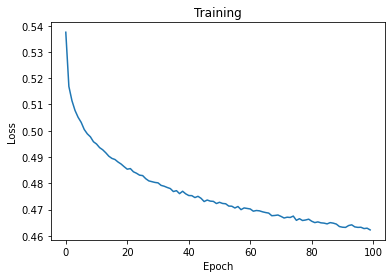

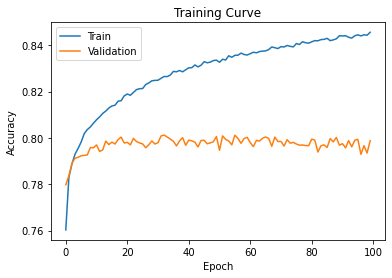

In [21]:
train(model, train_loader, test_loader, num_epochs=100, learning_rate=1e-3)

### Vectorize

We vectorize again with a smaller dimension for the embeddings to help the algorithms to converge

In [22]:
VECT_DIM = 100

In [23]:
embeddings = torchtext.vocab.GloVe(name="twitter.27B", dim=VECT_DIM, max_vectors=1000000)

In [24]:
X = vectorize(df.tweet)

100%|██████████| 196970/196970 [01:05<00:00, 2993.20it/s]

0.027150685500539676


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

### Logistic Regression

In [26]:
LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred3 = LRmodel.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      9951
           1       0.73      0.80      0.76      9746

    accuracy                           0.75     19697
   macro avg       0.75      0.75      0.75     19697
weighted avg       0.75      0.75      0.75     19697



### Support Vector Machine

In [27]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC(verbose=1, max_iter=1000)
LSVC.fit(X_train, y_train)
y_pred3 = LSVC.predict(X_test)
print(classification_report(y_test, y_pred3))

[LibLinear]              precision    recall  f1-score   support

           0       0.61      0.92      0.73      9951
           1       0.83      0.40      0.54      9746

    accuracy                           0.66     19697
   macro avg       0.72      0.66      0.64     19697
weighted avg       0.72      0.66      0.64     19697



c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
